In [7]:
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 799.2 kB/s eta 0:04:30
   ---------------------------------------- 0.8/216.1 MB 932.9 kB/s eta 0:03:51
   ---------------------------------------- 0.8/216.1 MB 932.9 kB/s eta 0:03:51
   ---------------------------------------- 1.3/216.1 MB 1.1 MB/s eta 0:03:22
   ---------------------------------------- 1.6/216.1 MB 1.1 MB/s eta 0:03:20
   ---------------------------------------- 1.8/216.1 MB 1.1 MB/s eta 0:03:16
   ---------------------------------------- 2.1/216.1 MB 1.1 MB/s eta 0:03:08
   ----------------------------

In [15]:
# --------------------- Import necessary libraries ---------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

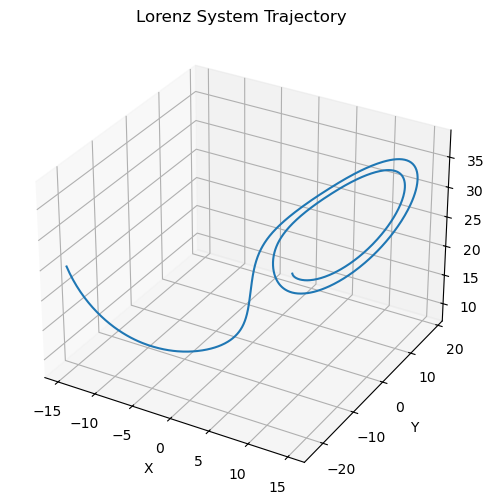

In [185]:
# --------------------- Simulate Lorenz system and plot data ---------------------
# Lorenz system parameters
sigma = 10.0
beta = 8/3
rho = 28.0

# Lorenz ODE system
def lorenz_ode(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial condition and time setup
t_span = (0, 2)
t_eval = np.linspace(*t_span, 1000)
initial_state = [4.0, 3.0, 19.0]

# Simulate trajectory
sol = solve_ivp(lorenz_ode, t_span, initial_state, t_eval=t_eval, method='RK45')
x, y, z = sol.y

# Plot Lorenz trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title('Lorenz System Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

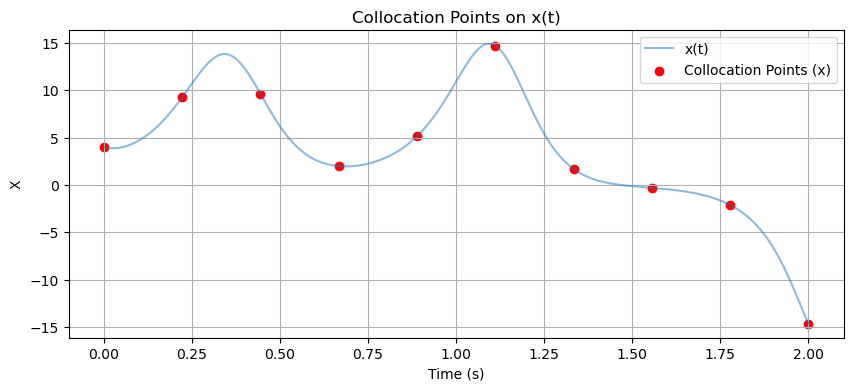

In [209]:
# --- Code Cell ---
# Select collocation points
num_collocation = 10
collocation_idx = np.linspace(0, len(t_eval)-1, num_collocation, dtype=int)

t_collocation = t_eval[collocation_idx]
x_collocation = x[collocation_idx]
y_collocation = y[collocation_idx]
z_collocation = z[collocation_idx]

# Plot collocation points on X(t)
plt.figure(figsize=(10, 4))
plt.plot(t_eval, x, label='x(t)', alpha=0.5)
plt.scatter(t_collocation, x_collocation, color='red', label='Collocation Points (x)')
plt.xlabel('Time (s)')
plt.ylabel('X')
plt.title('Collocation Points on x(t)')
plt.legend()
plt.grid(True)
plt.show()

In [211]:
# Hyperparameters
epochs = 15000

In [213]:
# Prepare training data (collocation points)
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(np.vstack([x_collocation, y_collocation, z_collocation]).T, dtype=torch.float32)

# Define the network
class LorenzNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 3)
        )
    def forward(self, t):
        return self.net(t)

In [215]:
# Instantiate model, optimizer and loss
model = LorenzNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 234.245636
Epoch 1000, Loss: 35.952114
Epoch 2000, Loss: 29.140009
Epoch 3000, Loss: 4.265460
Epoch 4000, Loss: 0.076744


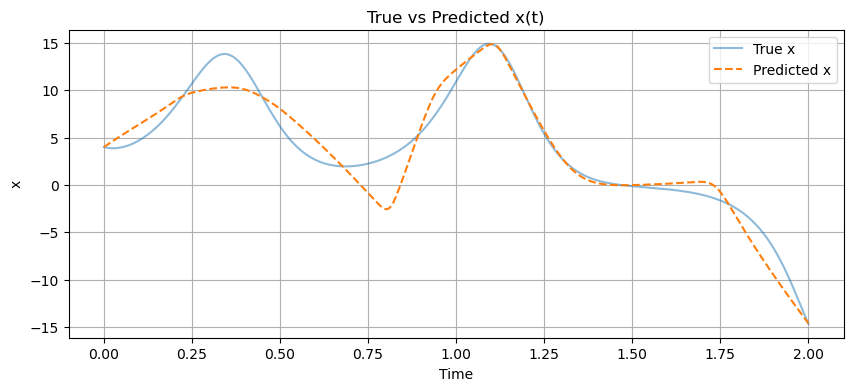

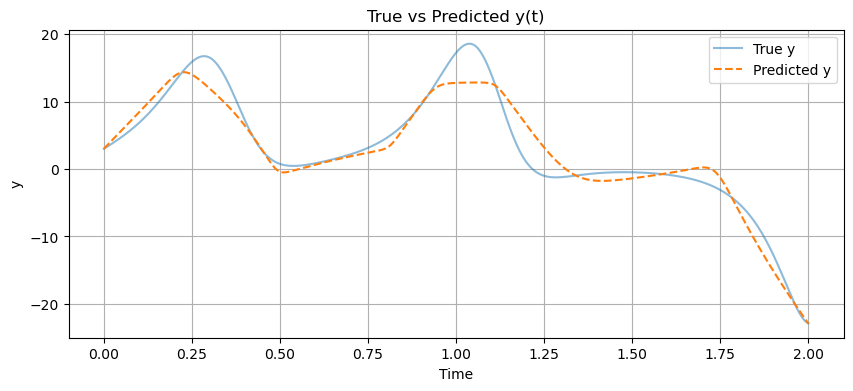

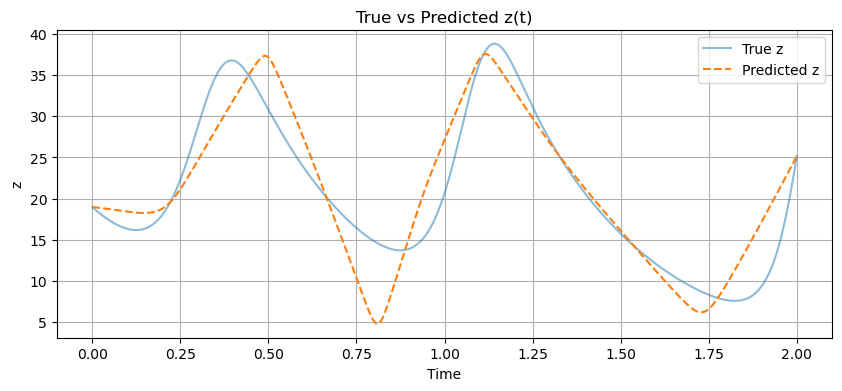

In [216]:
# Evaluate model on full time range
t_all = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    pred_all = model(t_all).numpy()

# Plot predictions vs. true values
plt.figure(figsize=(10, 4))
plt.plot(t_eval, x, label='True x', alpha=0.5)
plt.plot(t_eval, pred_all[:, 0], '--', label='Predicted x')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('True vs Predicted x(t)')
plt.legend()
plt.grid(True)
plt.show()

# Repeat for y and z
plt.figure(figsize=(10, 4))
plt.plot(t_eval, y, label='True y', alpha=0.5)
plt.plot(t_eval, pred_all[:, 1], '--', label='Predicted y')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('True vs Predicted y(t)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t_eval, z, label='True z', alpha=0.5)
plt.plot(t_eval, pred_all[:, 2], '--', label='Predicted z')
plt.xlabel('Time')
plt.ylabel('z')
plt.title('True vs Predicted z(t)')
plt.legend()
plt.grid(True)
plt.show()

## PINN

In [219]:
# Convert to torch tensors
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1).requires_grad_()
x_true = torch.tensor(x[collocation_idx], dtype=torch.float32).unsqueeze(1)
y_true = torch.tensor(y[collocation_idx], dtype=torch.float32).unsqueeze(1)
z_true = torch.tensor(z[collocation_idx], dtype=torch.float32).unsqueeze(1)

In [221]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, t):
        return self.net(t)

model = PINN()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)
loss_fn = nn.MSELoss()

In [233]:
# ---------------- Training Loop ---------------- #
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    pred = model(t_train)
    x_pred, y_pred, z_pred = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

    # Compute time derivatives
    dxdt = torch.autograd.grad(x_pred, t_train, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]
    dydt = torch.autograd.grad(y_pred, t_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    dzdt = torch.autograd.grad(z_pred, t_train, grad_outputs=torch.ones_like(z_pred), create_graph=True)[0]

    # Physics-informed residuals
    res1 = dxdt - sigma * (y_pred - x_pred)
    res2 = dydt - (x_pred * (rho - z_pred) - y_pred)
    res3 = dzdt - (x_pred * y_pred - beta * z_pred)
    physics_loss = (res1**2 + res2**2 + res3**2).mean()

    # Data loss from observations
    data_loss = loss_fn(x_pred, x_true) + loss_fn(y_pred, y_true) + loss_fn(z_pred, z_true)

    # Total loss
    """
    _lambda = .1
    if epoch < 10000:
        loss = data_loss
    else:
        loss = data_loss + _lambda * physics_loss
    """
    loss = data_loss + physics_loss
    
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f} | Data = {data_loss.item():.6f} | Physics = {physics_loss.item():.6f}")


Epoch 0: Total Loss = 1.044381 | Data = 0.721546 | Physics = 0.322834
Epoch 500: Total Loss = 0.593379 | Data = 0.592670 | Physics = 0.000709
Epoch 1000: Total Loss = 0.508355 | Data = 0.507710 | Physics = 0.000645
Epoch 1500: Total Loss = 0.505169 | Data = 0.442705 | Physics = 0.062464
Epoch 2000: Total Loss = 0.395256 | Data = 0.389923 | Physics = 0.005333
Epoch 2500: Total Loss = 0.351927 | Data = 0.351478 | Physics = 0.000449
Epoch 3000: Total Loss = 0.322908 | Data = 0.319567 | Physics = 0.003341
Epoch 3500: Total Loss = 0.293251 | Data = 0.292907 | Physics = 0.000345
Epoch 4000: Total Loss = 0.328143 | Data = 0.275321 | Physics = 0.052823
Epoch 4500: Total Loss = 0.255466 | Data = 0.254939 | Physics = 0.000527


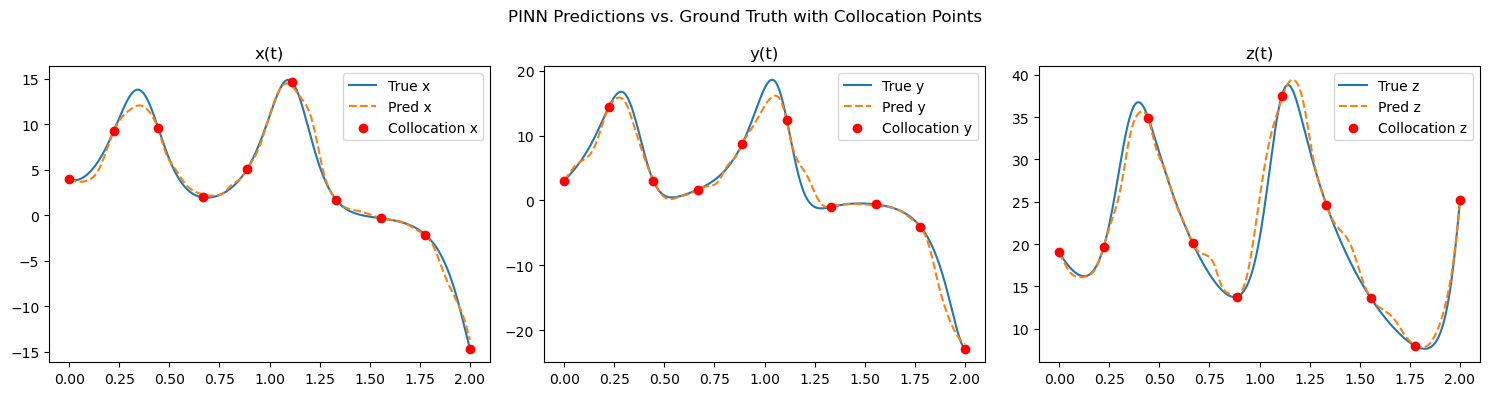

In [237]:
# ---------------- Evaluation ---------------- #
t_tensor = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    pred = model(t_tensor).numpy()
    x_pred, y_pred, z_pred = pred[:, 0], pred[:, 1], pred[:, 2]

# ---------------- Plotting ---------------- #
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# x(t)
axs[0].plot(t_eval, x, label='True x')
axs[0].plot(t_eval, x_pred, '--', label='Pred x')
axs[0].scatter(t_collocation, x_true.detach().numpy(), color='red', label='Collocation x', zorder=5)
axs[0].set_title("x(t)")
axs[0].legend()

# y(t)
axs[1].plot(t_eval, y, label='True y')
axs[1].plot(t_eval, y_pred, '--', label='Pred y')
axs[1].scatter(t_collocation, y_true.detach().numpy(), color='red', label='Collocation y', zorder=5)
axs[1].set_title("y(t)")
axs[1].legend()

# z(t)
axs[2].plot(t_eval, z, label='True z')
axs[2].plot(t_eval, z_pred, '--', label='Pred z')
axs[2].scatter(t_collocation, z_true.detach().numpy(), color='red', label='Collocation z', zorder=5)
axs[2].set_title("z(t)")
axs[2].legend()

plt.suptitle("PINN Predictions vs. Ground Truth with Collocation Points")
plt.tight_layout()
plt.show()


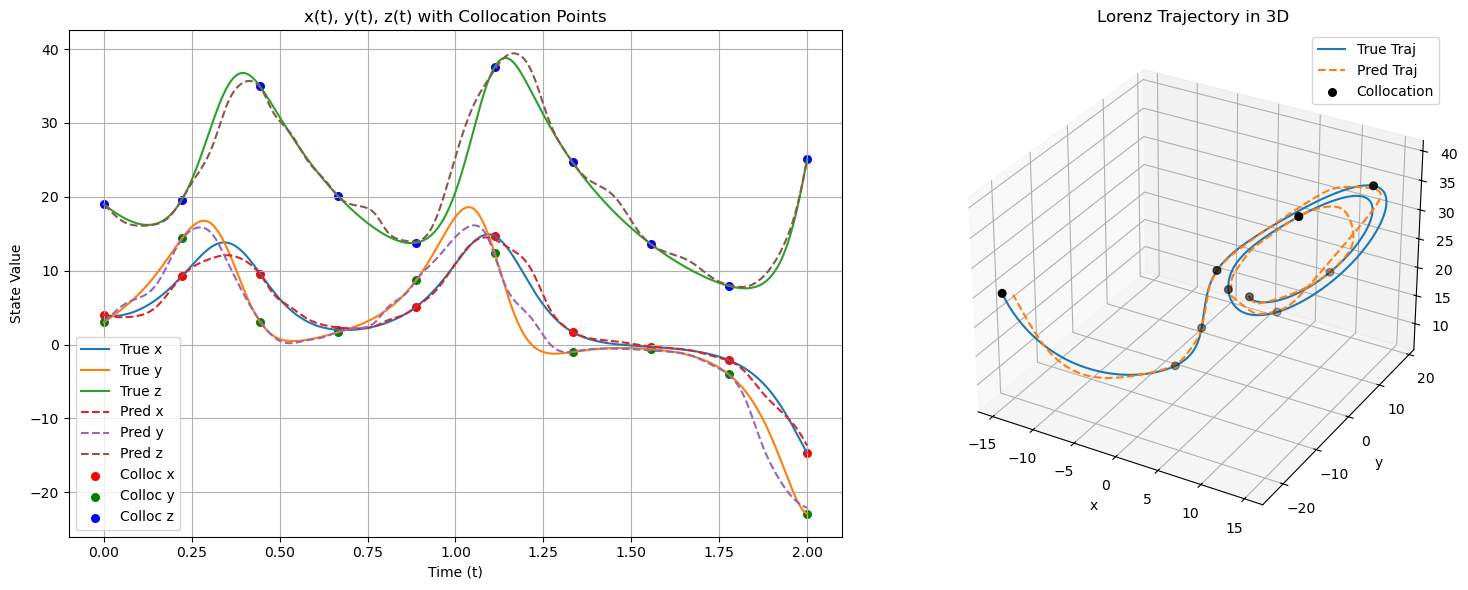

In [239]:
from mpl_toolkits.mplot3d import Axes3D

# ---------------- Evaluation ---------------- #
t_tensor = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    pred = model(t_tensor).numpy()
    x_pred, y_pred, z_pred = pred[:, 0], pred[:, 1], pred[:, 2]

# ---------------- Combined Plot ---------------- #
fig = plt.figure(figsize=(16, 6))

# Time-series subplots (x, y, z vs t)
ax1 = fig.add_subplot(1, 2, 1)

# Plot x(t), y(t), z(t)
ax1.plot(t_eval, x, label='True x')
ax1.plot(t_eval, y, label='True y')
ax1.plot(t_eval, z, label='True z')

ax1.plot(t_eval, x_pred, '--', label='Pred x')
ax1.plot(t_eval, y_pred, '--', label='Pred y')
ax1.plot(t_eval, z_pred, '--', label='Pred z')

# Collocation points
ax1.scatter(t_collocation, x_true.detach().numpy(), color='red', marker='o', s=30, label='Colloc x')
ax1.scatter(t_collocation, y_true.detach().numpy(), color='green', marker='o', s=30, label='Colloc y')
ax1.scatter(t_collocation, z_true.detach().numpy(), color='blue', marker='o', s=30, label='Colloc z')

ax1.set_xlabel("Time (t)")
ax1.set_ylabel("State Value")
ax1.set_title("x(t), y(t), z(t) with Collocation Points")
ax1.legend()
ax1.grid(True)

# 3D plot of Lorenz trajectory
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(x, y, z, label='True Traj', linewidth=1.5)
ax2.plot(x_pred, y_pred, z_pred, '--', label='Pred Traj', linewidth=1.5)

# Collocation points
ax2.scatter(x_true.detach().numpy(), y_true.detach().numpy(), z_true.detach().numpy(),
            color='black', label='Collocation', s=30)

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("Lorenz Trajectory in 3D")
ax2.legend()

plt.tight_layout()
plt.show()
